In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:

predict_students_dropout_and_academic_success = fetch_ucirepo(name="Predict Students' Dropout and Academic Success")

In [3]:

# Get the original dataset
student_data = predict_students_dropout_and_academic_success.data.original.copy()

# metadata
meta_data = predict_students_dropout_and_academic_success.variables

student_data.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
student_data.dtypes

Marital Status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

In [5]:
meta_data.head()

,name,role,type,demographic,description,units,missing_values
0,Marital Status,Feature,Integer,Marital Status,1 – single 2 – married 3 – widower 4 – divorce...,None,no
1,Application mode,Feature,Integer,None,1 - 1st phase - general contingent 2 - Ordinan...,None,no
2,Application order,Feature,Integer,None,Application order (between 0 - first choice; a...,None,no
3,Course,Feature,Integer,None,33 - Biofuel Production Technologies 171 - Ani...,None,no
4,Daytime/evening attendance,Feature,Integer,None,1 – daytime 0 - evening,None,no



### Exploring the data

In [6]:
explore_data = student_data.copy()

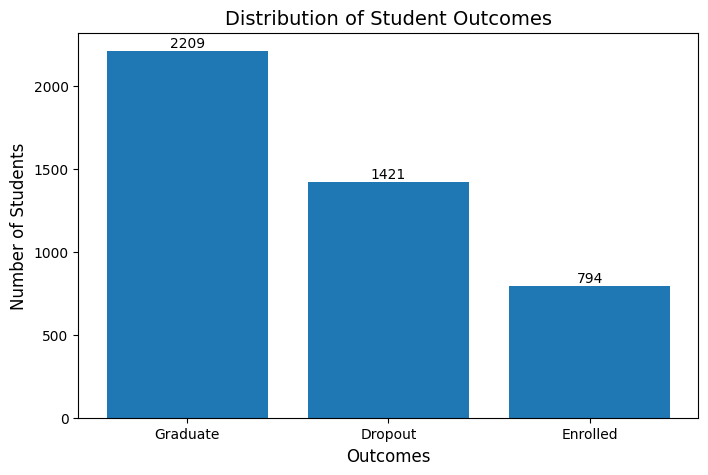

In [7]:

target_counts = explore_data["Target"].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values)
plt.xlabel("Outcomes", fontsize=12)
plt.ylabel("Number of Students", fontsize=12)
plt.title("Distribution of Student Outcomes", fontsize=14)
plt.xticks(rotation=0, ha="center")
for i, count in enumerate(target_counts.values):
    plt.text(i, count + 5, str(count), ha="center", va="bottom", fontsize=10)

plt.show()


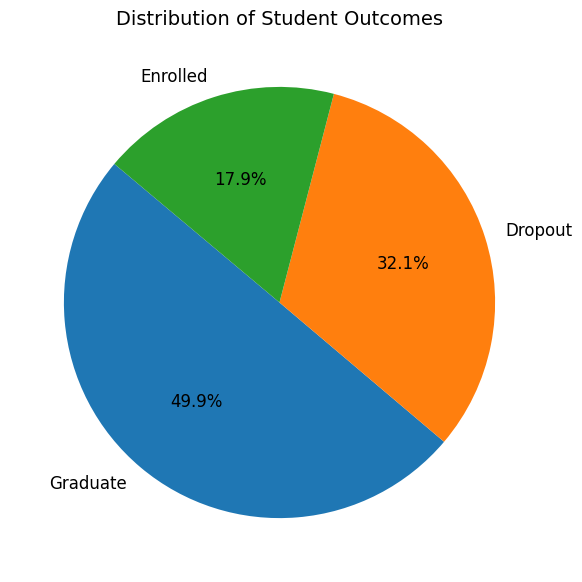

In [8]:

plt.figure(figsize=(7, 7))
plt.pie(
    target_counts.values,
    labels=target_counts.index,
    autopct=lambda p: "{:.1f}%".format(p),
    startangle=140, 
    textprops={"fontsize": 12},
)
plt.title("Distribution of Student Outcomes", fontsize=14)
plt.show()


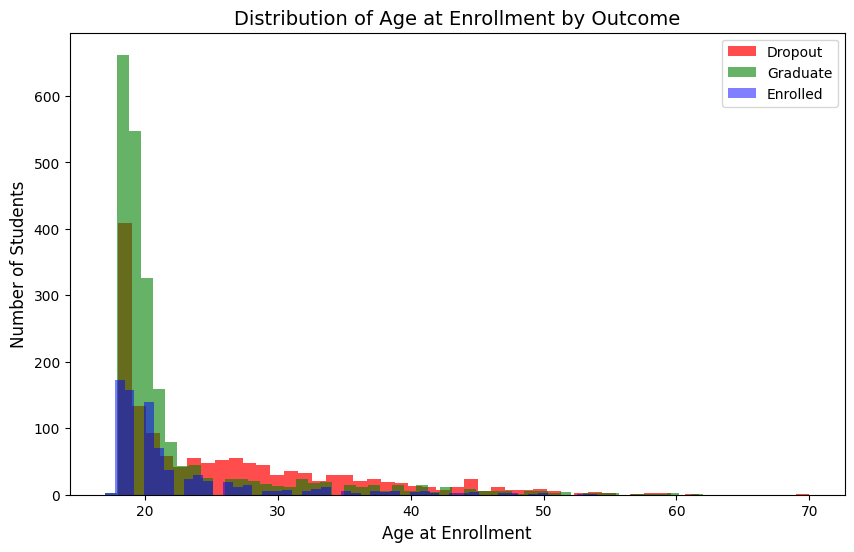

In [9]:
dropout_data = explore_data[explore_data["Target"] == "Dropout"]
graduate_data = explore_data[explore_data["Target"] == "Graduate"]
enrolled_data = explore_data[explore_data["Target"] == "Enrolled"]

plt.figure(figsize=(10, 6))
plt.hist(
    dropout_data["Age at enrollment"],
    bins=50,  # Adjust bin number as needed
    alpha=0.7,
    label="Dropout",
    color="red",
)
plt.hist(
    graduate_data["Age at enrollment"],
    bins=50,
    alpha=0.6,
    label="Graduate",
    color="green",
)
plt.hist(
    enrolled_data["Age at enrollment"],
    bins=50,
    alpha=0.5, 
    label="Enrolled",
    color="blue",
)

plt.xlabel("Age at Enrollment", fontsize=12)
plt.ylabel("Number of Students", fontsize=12)
plt.title("Distribution of Age at Enrollment by Outcome", fontsize=14)
plt.legend()
plt.show()


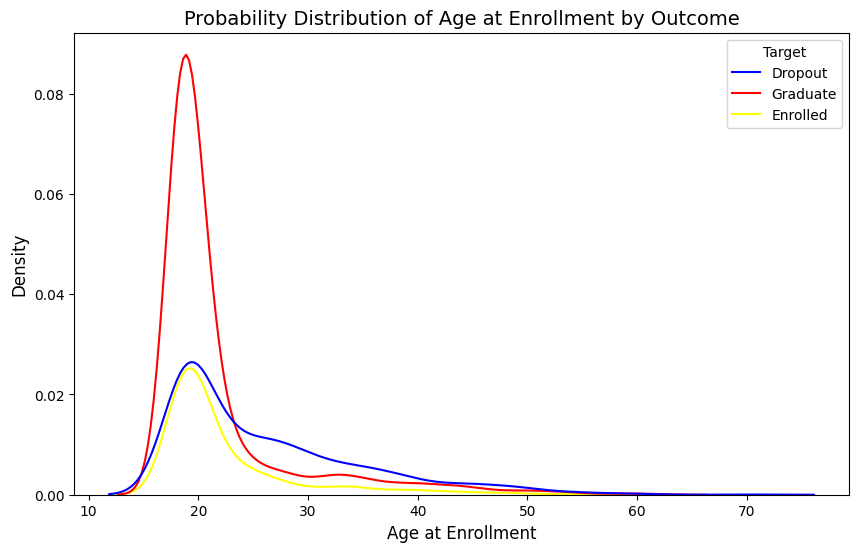

In [10]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=explore_data,
    x="Age at enrollment",
    hue="Target",
    fill=False,
    alpha=1, 
    palette={"Dropout": "blue", "Graduate": "red", "Enrolled": "yellow"},
)
plt.xlabel("Age at Enrollment", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Probability Distribution of Age at Enrollment by Outcome", fontsize=14)
plt.show()


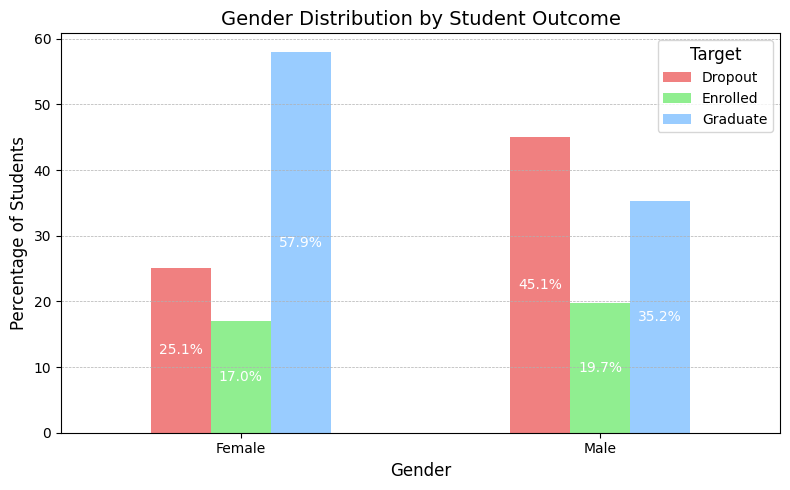

In [11]:

explore_data["Gender"] = explore_data["Gender"].replace({0: "Female", 1: "Male"})
gender_target_counts = pd.crosstab(explore_data["Gender"], explore_data["Target"], normalize="index") * 100

colors = ["#F08080", "#90EE90", "#99ccff"]
ax = gender_target_counts.plot(kind="bar", figsize=(8, 5), color=colors)

plt.xlabel("Gender", fontsize=12)
plt.ylabel("Percentage of Students", fontsize=12)  # Update y-axis label
plt.title("Gender Distribution by Student Outcome", fontsize=14)
plt.xticks(rotation=0, ha="center")
plt.legend(title="Target", title_fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()


for p in ax.patches:
    percentage = "{:.1f}%".format(p.get_height())  # Format as percentage
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2.0, p.get_height() / 2.0),
        ha="center",
        va="center",
        fontsize=10,
        color="white",
    )


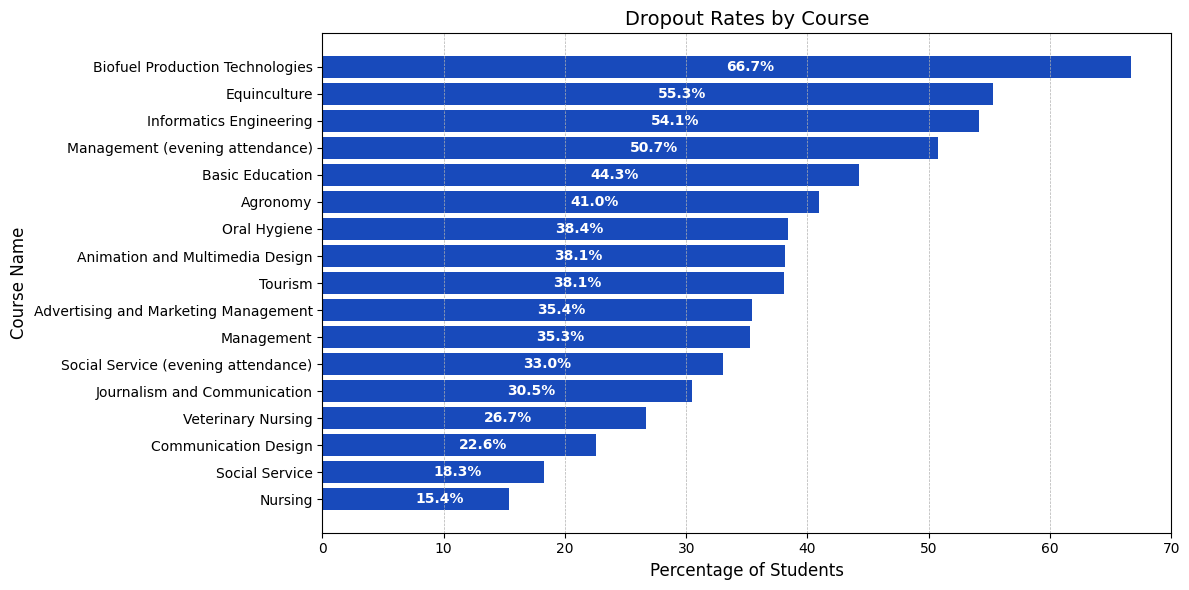

In [12]:
courses_map = {33:'Biofuel Production Technologies', 171:'Animation and Multimedia Design', 8014:'Social Service (evening attendance)', 9003:'Agronomy', 9070:'Communication Design', 9085:'Veterinary Nursing', 9119:'Informatics Engineering', 9130:'Equinculture', 9147:'Management', 9238:'Social Service', 9254:'Tourism', 9500:'Nursing', 9556:'Oral Hygiene', 9670:'Advertising and Marketing Management', 9773:'Journalism and Communication', 9853:'Basic Education', 9991:'Management (evening attendance)'}


explore_data["Course Name"] = explore_data["Course"].map(courses_map)

course_target_counts = (
        pd.crosstab(explore_data["Course Name"], explore_data["Target"], normalize="index") * 100
)

dropout_percentages = course_target_counts["Dropout"]
dropout_percentages = dropout_percentages.sort_values(ascending=True)

plt.figure(figsize=(12, 6))  
plt.barh(dropout_percentages.index, dropout_percentages.values, color="#184ABB")

plt.xlabel("Percentage of Students", fontsize=12)
plt.ylabel("Course Name", fontsize=12)
plt.title("Dropout Rates by Course", fontsize=14)
plt.yticks(rotation=0, ha="right")  # Rotate y-axis labels
plt.grid(axis="x", linestyle="--", linewidth=0.5)  # Add subtle gridlines to x-axis
plt.tight_layout()

for i, v in enumerate(dropout_percentages.values):
    plt.text(v / 2, i, "{:.1f}%".format(v), color="white", fontweight="bold", va="center")

plt.show()

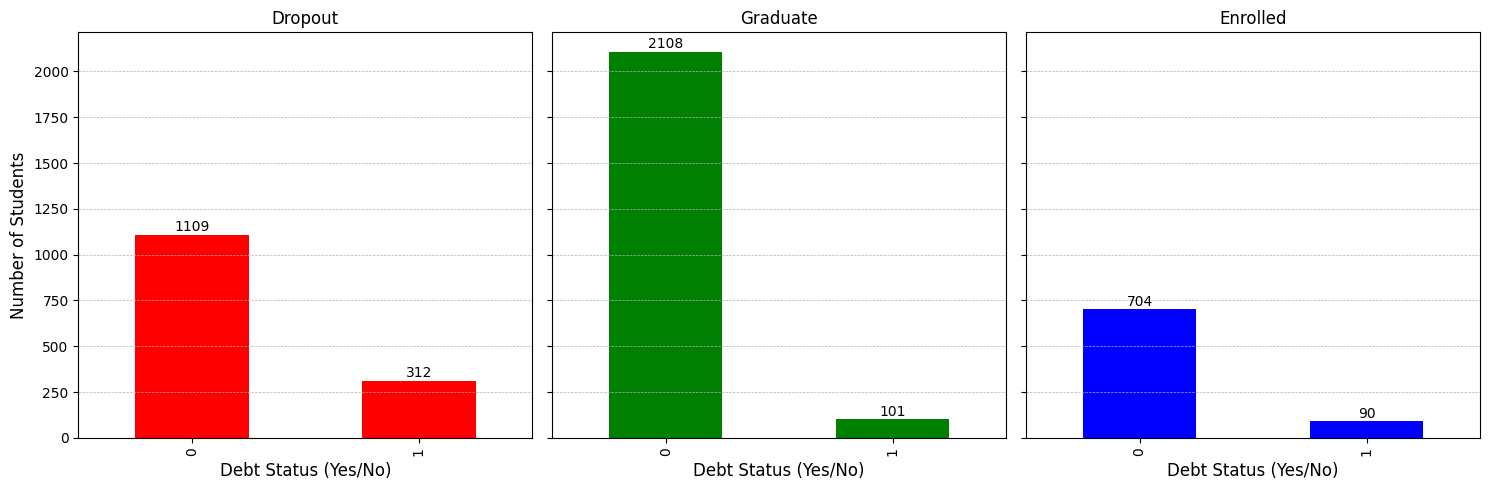

In [13]:
debt_counts_dropout = dropout_data["Debtor"].value_counts()
debt_counts_graduate = graduate_data["Debtor"].value_counts()
debt_counts_enrolled = enrolled_data["Debtor"].value_counts()


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  

debt_counts_dropout.plot(kind="bar", ax=axes[0], color="red", title="Dropout")
debt_counts_graduate.plot(kind="bar", ax=axes[1], color="green", title="Graduate")
debt_counts_enrolled.plot(kind="bar", ax=axes[2], color="blue", title="Enrolled")

for ax in axes:
    ax.set_xlabel("Debt Status (Yes/No)", fontsize=12)
    ax.set_ylabel("Number of Students", fontsize=12)
    ax.grid(axis="y", linestyle="--", linewidth=0.5)


for i, ax in enumerate(axes):
    for p in ax.patches:
        ax.annotate(
            str(p.get_height()),
            (p.get_x() + p.get_width() / 2.0, p.get_height() + 2),  # Adjust offset as needed
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

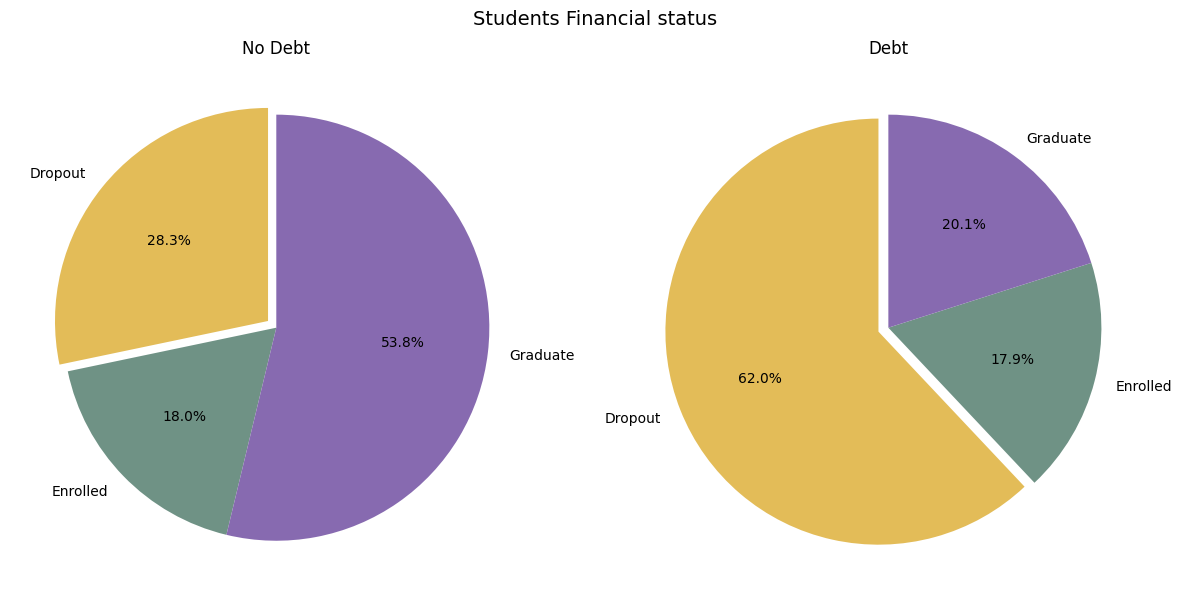

In [14]:
debt_target_counts = explore_data.groupby(["Debtor", "Target"])["Target"].count()

no_debt_data = debt_target_counts.loc[0]
debt_data = debt_target_counts.loc[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#E3BC58", "#6F9285", "#876AB0"]  
explode = (0.05, 0, 0)  

no_debt_data.plot(
    kind="pie",
    ax=axes[0],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
    title="No Debt",
)
debt_data.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
    title="Debt",
)

for ax in axes:
    ax.set_ylabel("")  
plt.suptitle("Students Financial status", fontsize=14, y=1.0)  # Overall title
plt.tight_layout()
plt.show()

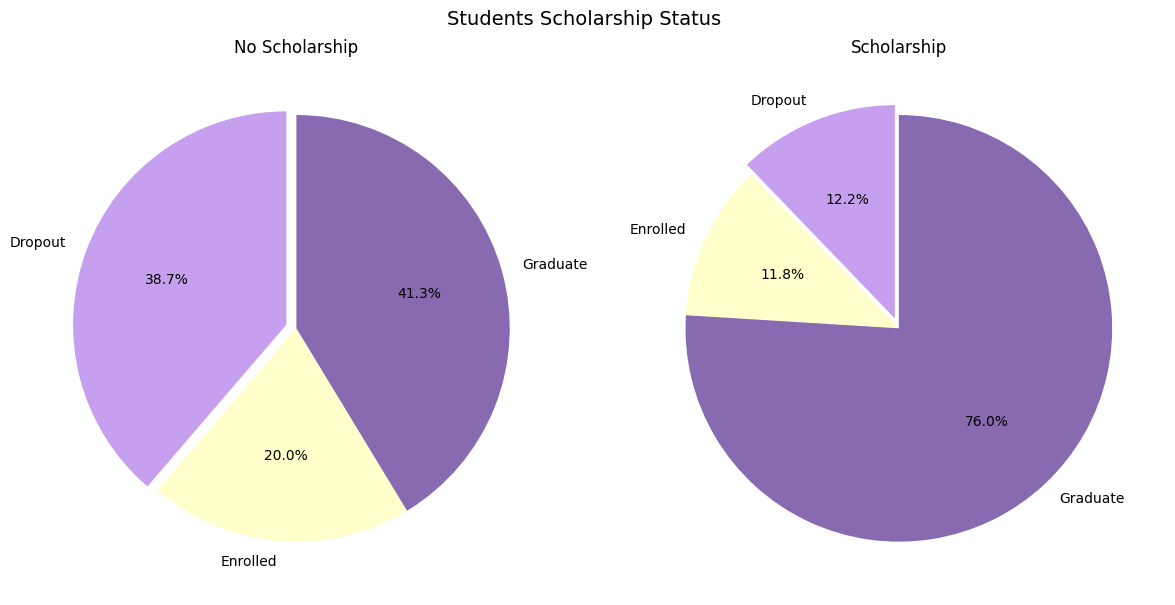

In [15]:
scholarship_target_counts = explore_data.groupby(["Scholarship holder", "Target"])["Target"].count()

no_scholarship_data = scholarship_target_counts.loc[0]
scholarship_data = scholarship_target_counts.loc[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colors = ["#C79FEF", "#FFFFCB", "#876AB0"]
explode = (0.05, 0, 0)


no_scholarship_data.plot(
    kind="pie",
    ax=axes[0],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
    title="No Scholarship",
)
scholarship_data.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
    title="Scholarship",
)

for ax in axes:
    ax.set_ylabel("")

plt.suptitle("Students Scholarship Status", fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

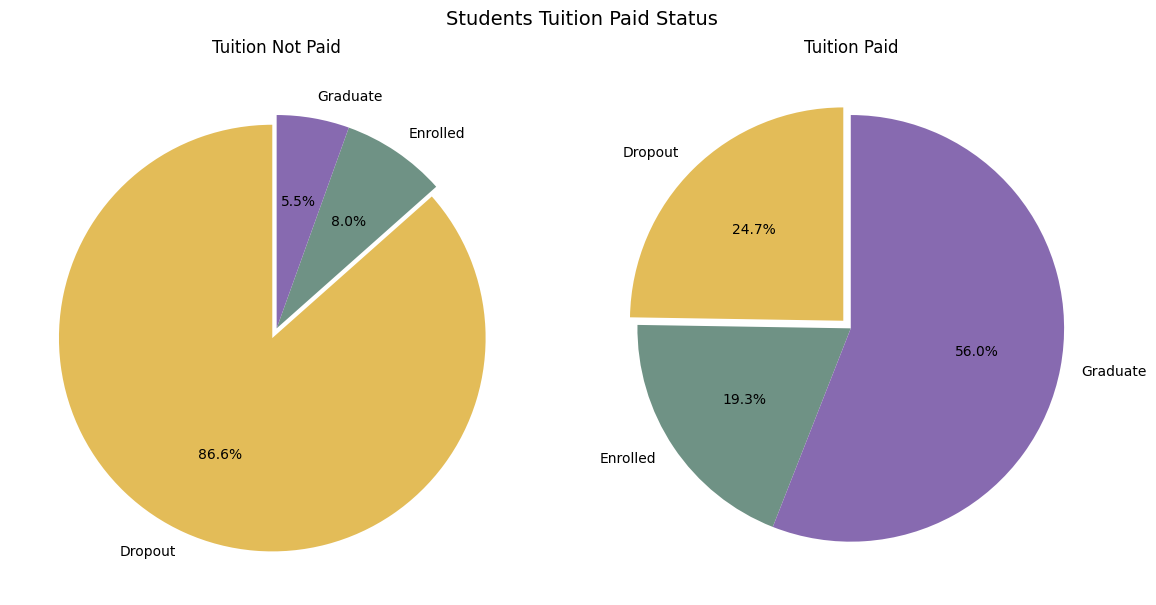

In [16]:
tuition_target_counts = explore_data.groupby(["Tuition fees up to date", "Target"])["Target"].count()
tuition_not_paid_data = tuition_target_counts.loc[0]
tuition_paid_data = tuition_target_counts.loc[1]


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colors = ["#E3BC58", "#6F9285", "#876AB0"]
explode = (0.05, 0, 0)

tuition_not_paid_data.plot(
    kind="pie",
    ax=axes[0],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
    title="Tuition Not Paid",
)
tuition_paid_data.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
    title="Tuition Paid",
)

for ax in axes:
    ax.set_ylabel("")

plt.suptitle("Students Tuition Paid Status", fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

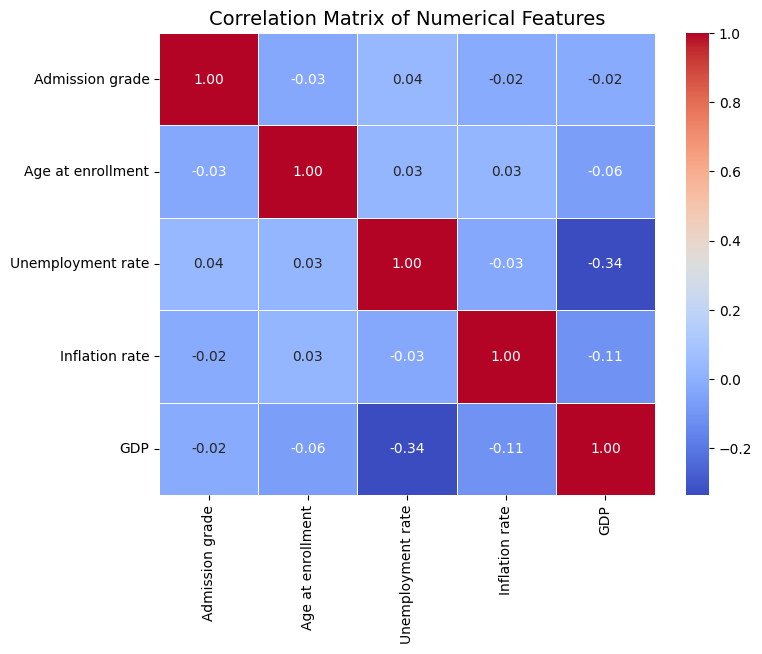

In [17]:
numerical_columns = [
    "Admission grade",
    "Age at enrollment",
    "Unemployment rate",
    "Inflation rate",
    "GDP",
]
data_numeric = explore_data[numerical_columns]


correlation_matrix = data_numeric.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm", 
    fmt=".2f",  
    linewidths=0.5,
)
plt.title("Correlation Matrix of Numerical Features", fontsize=14)
plt.show()

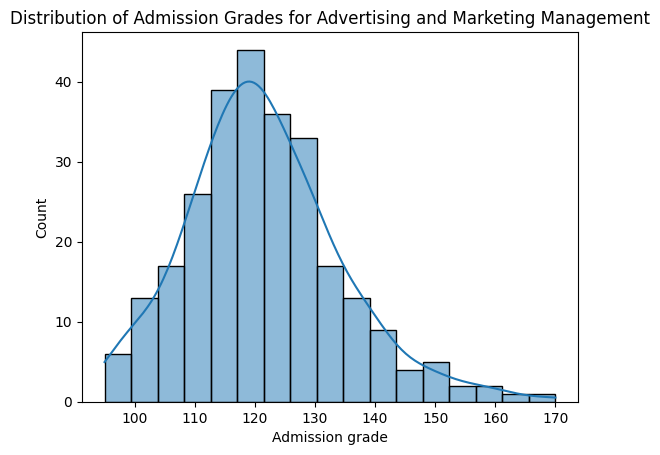

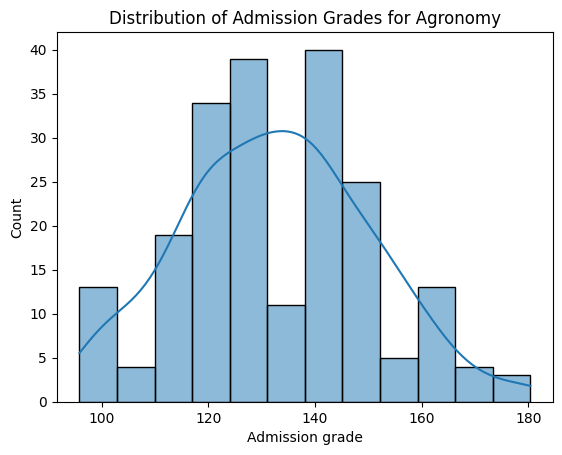

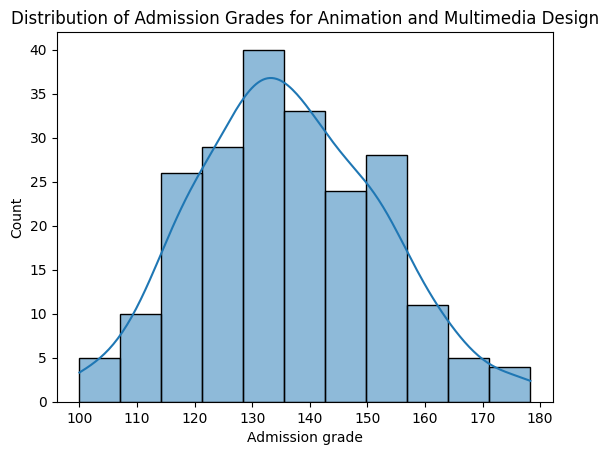

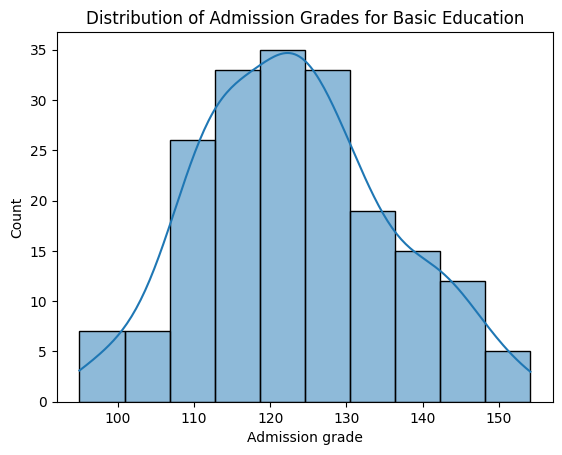

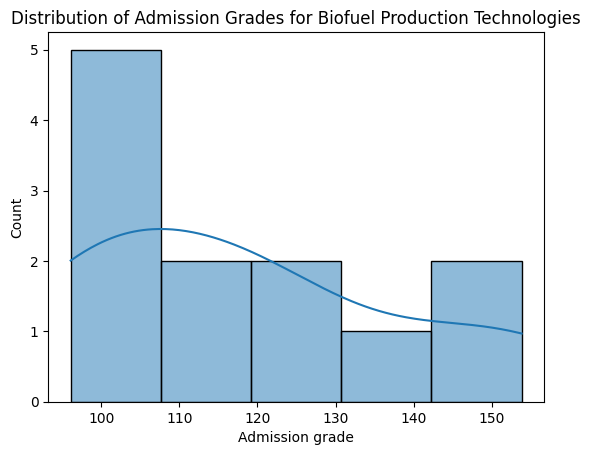

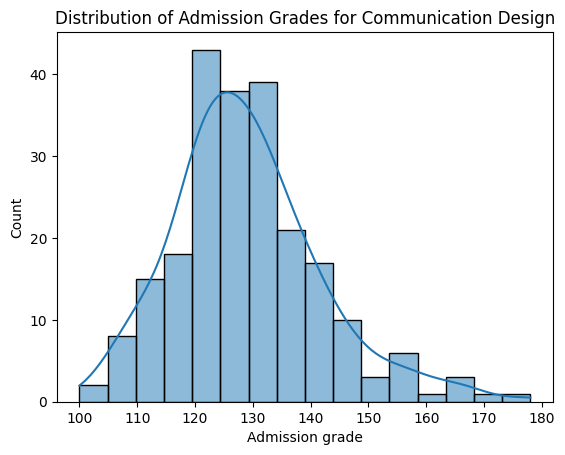

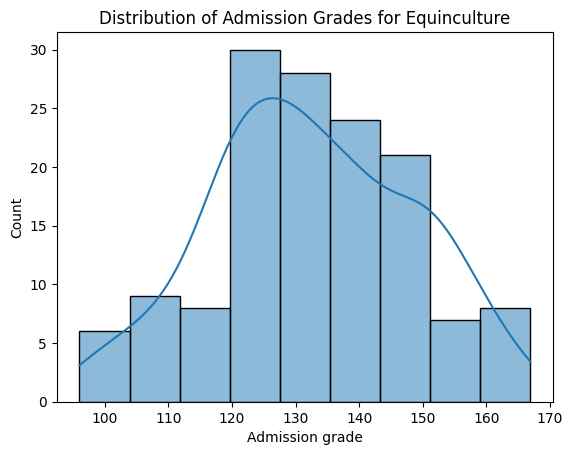

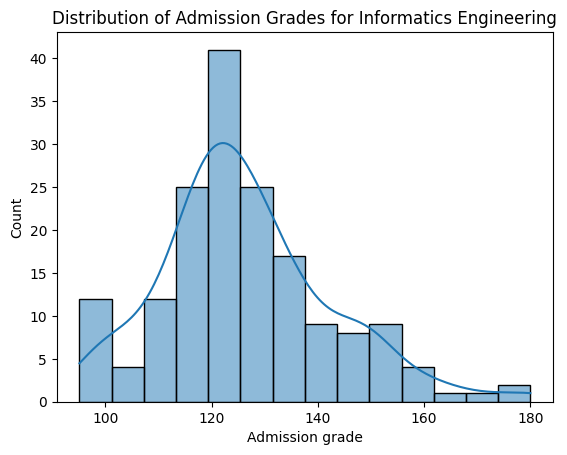

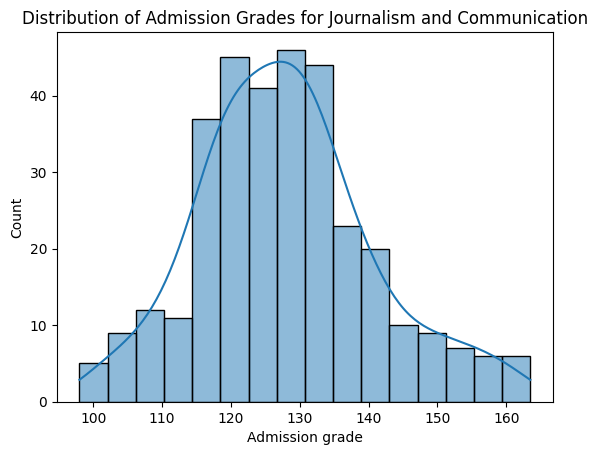

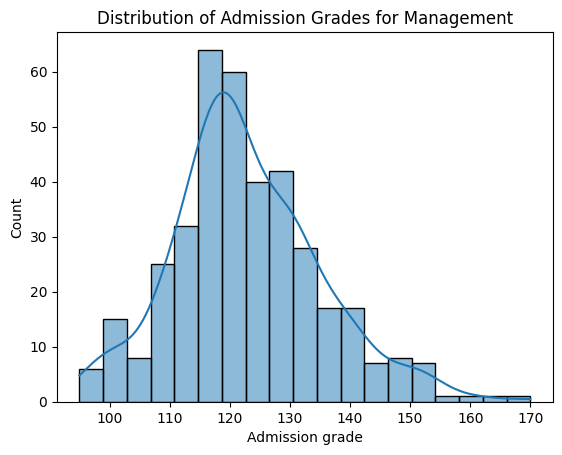

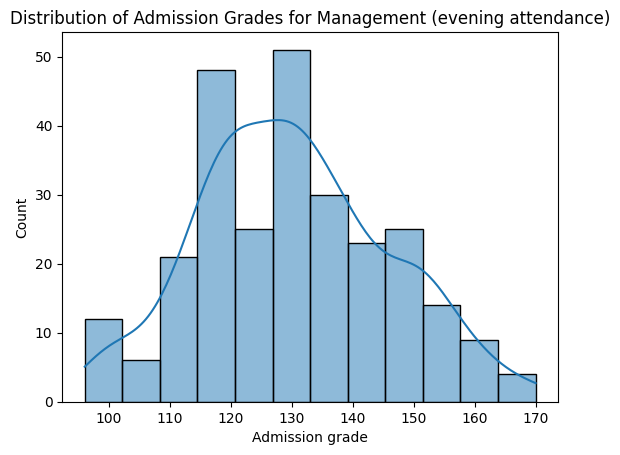

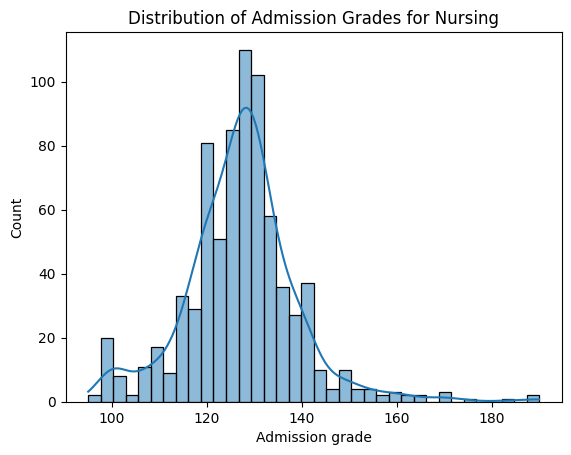

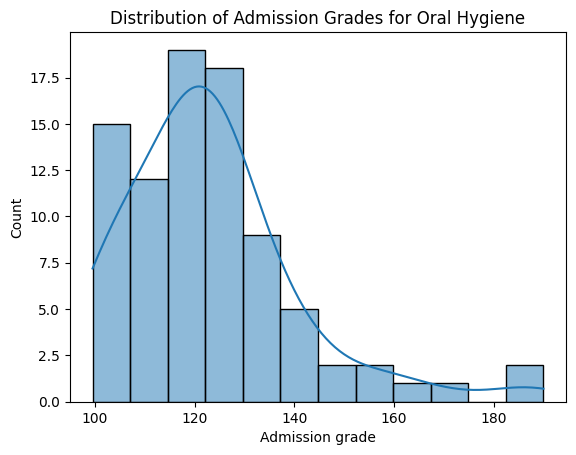

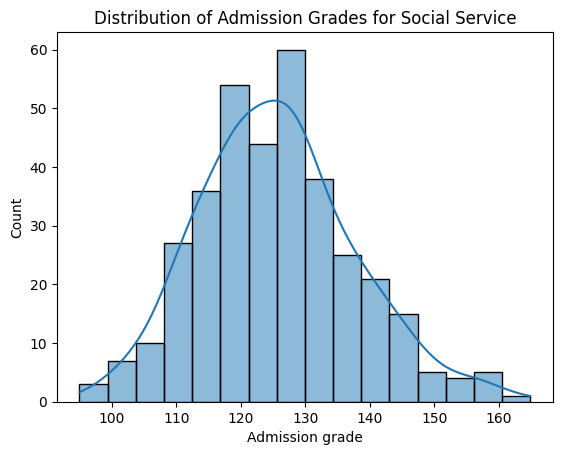

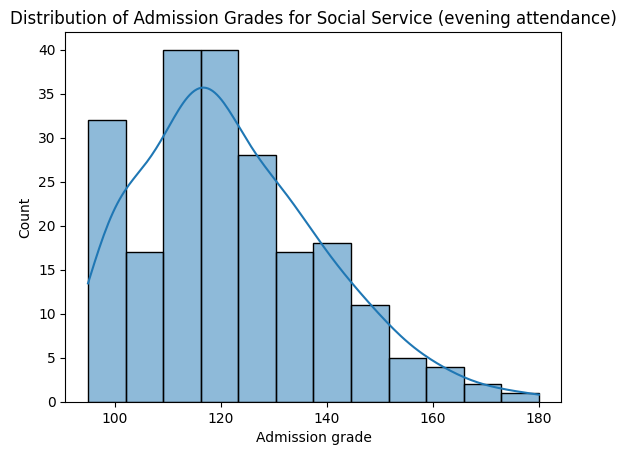

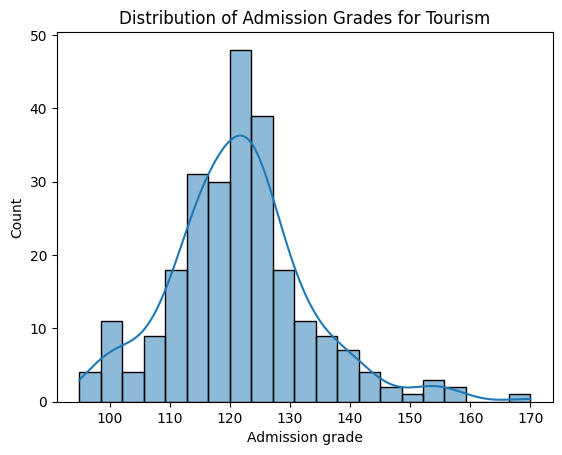

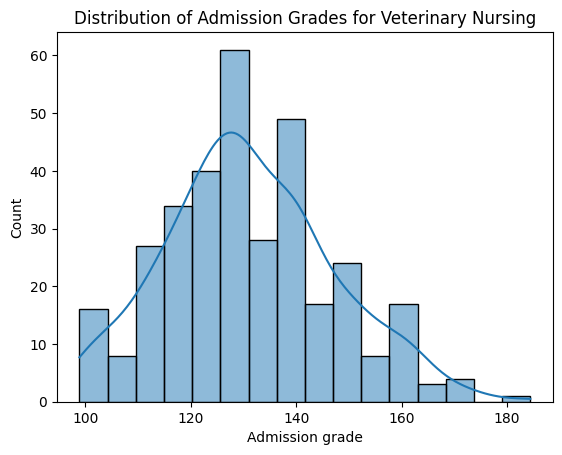

In [18]:
for course_name, course_data in explore_data.groupby("Course Name"):
    plt.figure()
    sns.histplot(course_data["Admission grade"], kde=True)
    plt.title(f"Distribution of Admission Grades for {course_name}")
    plt.show()

### Pre-processing

#####  Checking for null values

In [19]:
student_data.rename(columns = {'Nacionality':'Nationality'}, inplace = True)
student_data.isna().sum()

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [20]:
student_data.duplicated().sum()

0

In [21]:
student_data = student_data[student_data['Target'] != 'Enrolled']
student_data.reset_index(drop=True, inplace=True)

In [22]:
mapping = {"Graduate": 0, "Dropout": 1}
student_data['Target'] = student_data['Target'].map(mapping)
student_data

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,0
3626,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,1
3627,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,1
3628,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,0



#### Identifying and Removing Outliers (only in non-categorical features that have high correlations)

<AxesSubplot: >

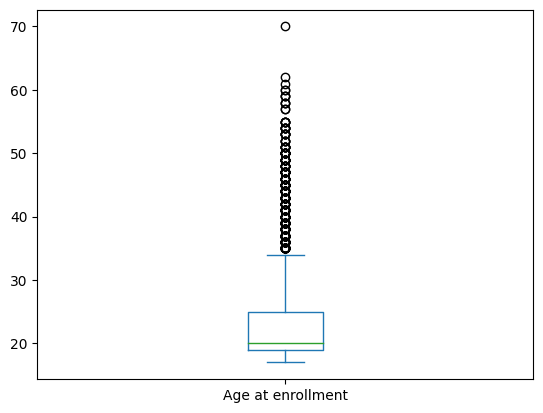

In [23]:

student_data['Age at enrollment'].plot(kind='box')

In [24]:

student_data = student_data[student_data['Age at enrollment'] < 35]
student_data.shape

(3241, 37)

<AxesSubplot: >

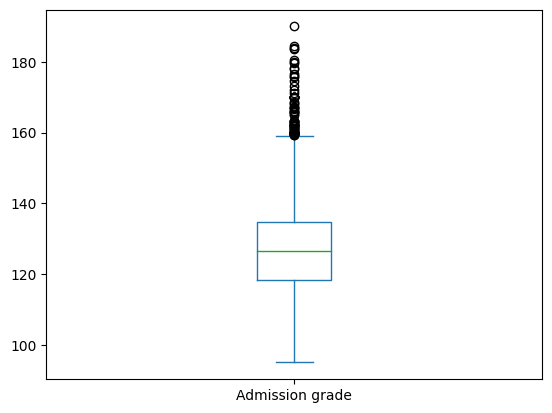

In [25]:
student_data['Admission grade'].plot(kind='box')

In [26]:

student_data = student_data[student_data['Admission grade'] < 160]
student_data.shape

(3154, 37)

#### Understanding Class Distributions

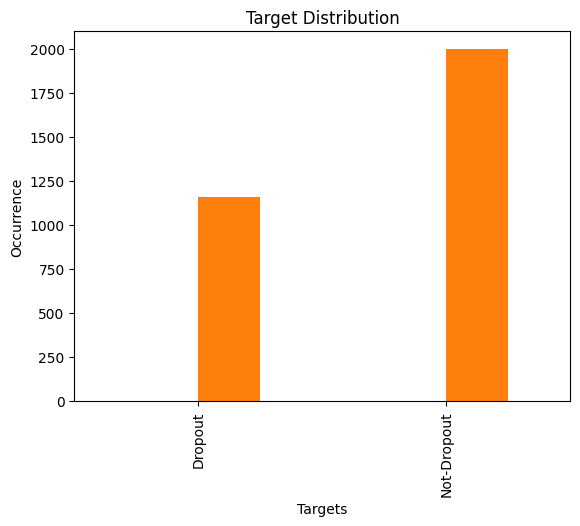

In [27]:
unique_targets = student_data['Target'].unique().tolist()
class_distributions = dict()
for target in unique_targets:
  class_distributions[target] = student_data[student_data['Target'] == target]['Target'].count()
class_dist = pd.DataFrame({'target':class_distributions.keys(), 'occurrence':class_distributions.values()})
ax = class_dist.plot(kind='bar', title='Target Distribution', xlabel='Targets', ylabel='Occurrence', legend=False)
plt.xticks([0, 1], ['Dropout', 'Not-Dropout'])
plt.show()

In [28]:
for target in unique_targets:
    print(target,' = ', round(int(class_dist[class_dist['target']== target]['occurrence'])*100/class_dist['occurrence'].sum(),2),'%')

1  =  36.68 %
0  =  63.32 %


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
6,1,1,1,9500,1,1,142.0,1,19,38,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,0
3626,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,1
3627,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,1
3628,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,0


In [30]:
student_data.to_csv('processed_student_data.csv', index=False)

#### analysis summary

# Student Dropout Prediction - EDA Summary Report

## Dataset Overview
- **Source**: UCI Machine Learning Repository - "Predict Students' Dropout and Academic Success"
- **Initial Size**: 4,424 students with 37 features
- **Final Size**: 3,154 students (after removing 'Enrolled' class and outliers)
- **Target Classes**: Binary classification - Graduate (0) vs Dropout (1)
- **Data Quality**: No missing values, no duplicates

---

## Key Findings

### 1. Class Distribution
- **Original Distribution**: 
  - Graduate: 63.32%
  - Dropout: 36.68%
  - Status: Imbalanced dataset
- **After Balancing (Random Over Sampling)**:
  - Graduate: 50% (1,997 samples)
  - Dropout: 50% (1,997 samples)
  - Total balanced dataset: 3,994 samples

### 2. Financial Factors (Strongest Predictors)

#### **Debt Status**
- Students with debt: ~70% dropout rate
- Students without debt: Majority graduate
- **Insight**: Financial burden is the single strongest indicator of dropout risk

#### **Scholarship Status**
- Scholarship holders: ~80% graduation rate
- Non-scholarship students: ~40% dropout rate
- **Insight**: Financial support significantly improves student retention

#### **Tuition Payment Status**
- Tuition not paid on time: ~80% dropout rate
- Tuition paid on time: Much higher graduation rates
- **Insight**: Current payment status is a critical early warning signal

### 3. Age at Enrollment

#### **Distribution Patterns**
- **Graduates**: Peak at 18-22 years (traditional college age)
- **Dropouts**: Broader distribution, peak at 25-35 years
- **Outliers Removed**: Students older than 35 years (statistical outliers)

#### **Key Insight**
- Younger students (18-22) have significantly higher graduation rates
- Older students face more challenges balancing education with life responsibilities
- Age is a significant predictor of academic outcome

### 4. Course Selection

#### **Highest Dropout Rates**
- Management (evening attendance): >50%
- Social Service (evening attendance): High dropout
- **Pattern**: Evening attendance courses consistently show higher dropout rates

#### **Lowest Dropout Rates**
- Nursing: <20%
- Oral Hygiene: <25%
- Veterinary Nursing: Low dropout
- **Pattern**: Healthcare-related courses have better retention

#### **Key Insight**
- Course type and attendance mode (evening vs daytime) significantly impact outcomes
- Evening students may face work-life balance challenges

### 5. Gender Analysis
- **Female students**: Slightly higher graduation rates (~5% difference)
- **Male students**: Slightly higher dropout rates
- **Insight**: Gender shows minor differences, not a strong predictor alone

### 6. Academic Performance Indicators
- **Admission Grades**: Vary significantly by course
- **Curricular Units Performance**: 
  - Grades from 1st and 2nd semester
  - Number of approved/failed units
  - Evaluations taken
- **Outliers Removed**: Admission grades >160 (unusual values)
- **Insight**: Academic performance metrics are crucial for prediction

### 7. Economic Indicators
- **Variables Analyzed**:
  - Unemployment rate
  - Inflation rate
  - GDP
- **Correlation**: Strong intercorrelation among economic indicators
  - Negative correlation between Inflation and GDP
- **Insight**: Macroeconomic conditions may impact student outcomes, though less directly than personal financial factors

### 8. Parental Background
- **Mother's qualification**
- **Father's qualification**
- **Mother's occupation**
- **Father's occupation**
- **Insight**: Family educational background included as demographic features

---

## Data Preprocessing Steps

### 1. **Missing Values**
- Result: Zero missing values across all features
- Action: No imputation required

### 2. **Duplicate Records**
- Result: Zero duplicates found
- Action: No removal needed

### 3. **Target Class Filtering**
- Removed: "Enrolled" class (students still in progress)
- Retained: "Graduate" and "Dropout" for binary classification
- Reason: Focus on completed outcomes

### 4. **Outlier Removal**
- **Age at Enrollment**: Removed students aged >35 years
  - Rationale: Statistical outliers, likely non-traditional cases
- **Admission Grade**: Removed grades >160
  - Rationale: Unusual values, potential data errors
- **Impact**: Dataset reduced from 3,630 to 3,154 rows

### 5. **Class Balancing**
- **Method**: Random Over Sampling (ROS)
- **Reason**: Address 63-37% class imbalance
- **Result**: Perfect 50-50 split for model training
- **Benefit**: Prevents model bias toward majority class

### 6. **Feature Encoding**
- Target variable mapped: Graduate → 0, Dropout → 1
- Categorical variables retained as integers (already encoded)

---

## Top Predictive Features (Based on EDA)

### **Tier 1 - Strongest Predictors**
1. **Debtor status** (Yes/No)
2. **Tuition fees up to date** (Yes/No)
3. **Scholarship holder** (Yes/No)

### **Tier 2 - Strong Predictors**
4. **Age at enrollment**
5. **Course type** (especially evening vs daytime)
6. **Curricular units performance** (grades, approvals)

### **Tier 3 - Moderate Predictors**
7. **Previous qualification and grades**
8. **Application order** (preference ranking)
9. **Gender**
10. **Parental education level**

### **Tier 4 - Contextual Predictors**
11. **Economic indicators** (unemployment, inflation, GDP)
12. **Marital status**
13. **International student status**

---

## Recommendations for Intervention

### **High-Risk Student Profile**
Based on EDA findings, students most at risk of dropping out:
- Have outstanding debts or unpaid tuition
- Do not have scholarships
- Are older than traditional college age (>25 years)
- Enrolled in evening programs
- Struggling with curricular units (low grades, failed evaluations)

### **Institutional Actions**
1. **Financial Support Programs**: 
   - Expand scholarship opportunities
   - Create emergency funding for students with debt
   - Flexible payment plans

2. **Early Warning Systems**:
   - Monitor tuition payment status monthly
   - Track first-semester academic performance
   - Flag students with multiple risk factors

3. **Targeted Support**:
   - Additional counseling for evening program students
   - Mentorship programs for non-traditional age students
   - Academic support for students struggling in first semester

4. **Course-Specific Interventions**:
   - Review evening program structure and support
   - Study successful retention strategies in healthcare programs
   - Apply best practices across all courses

---

## Data Characteristics for Modeling

### **Features**
- **Total Features**: 36 (after removing Target)
- **Feature Types**: 
  - Mostly integer-encoded categorical variables
  - Some continuous variables (grades, economic indicators)
- **No missing data**: Ready for machine learning models

### **Target Variable**
- **Type**: Binary classification
- **Classes**: 0 (Graduate), 1 (Dropout)
- **Balance**: Achieved through Random Over Sampling

### **Sample Size**
- **Training Data**: 3,994 samples (after balancing)
- **Sufficient**: Adequate for machine learning algorithms
- **Quality**: Clean data with outliers removed

---

## Visualization Summary

### **Created Visualizations**
1. Bar charts and pie charts for target distribution
2. Histograms and KDE plots for age distribution
3. Stacked bar charts for gender analysis
4. Horizontal bar charts for course-wise dropout rates
5. Multiple pie charts for financial factors (debt, scholarship, tuition)
6. Correlation heatmap for numerical features
7. Box plots for outlier detection
8. Distribution plots for admission grades by course

### **Key Visual Insights**
- Clear visual separation between graduate and dropout age distributions
- Dramatic pie chart differences between debt/no-debt outcomes
- Course dropout rates ranging from <20% to >50%
- Economic indicators showing intercorrelation patterns
